In [4]:
pip install imbalanced-learn xgboost joblib

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\asus\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [6]:
pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\asus\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [8]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\asus\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [9]:
# Import required libraries
from scipy.io import arff
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import Pipeline  # Changed to imblearn pipeline for SMOTE
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import (classification_report,
                             precision_recall_curve,
                             confusion_matrix, 
                             PrecisionRecallDisplay,
                             RocCurveDisplay)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json

In [10]:
# ---------------------
# 1. Data Preparation
# ---------------------
def load_and_preprocess(file_path):
    """Load and preprocess ARFF file with network traffic data"""
    data, meta = arff.loadarff(file_path)
    df = pd.DataFrame(data)
    
    # Convert byte strings to normal strings for class labels
    df['class1'] = df['class1'].str.decode('utf-8')
    
    # Handle missing values (represented by -1)
    df.replace(-1, np.nan, inplace=True)
    df = df.apply(lambda x: x.fillna(x.median()) if x.dtype != 'O' else x)
    
    return df

In [11]:
# ---------------------
# 2. Feature Engineering
# ---------------------
def engineer_features(df):
    """Create time-based features for encrypted traffic analysis"""
    df = df.copy()
    
    # Temporal pattern features
    df['flow_duration_per_packet'] = df['duration'] / (df['total_fiat'] + df['total_biat'] + 1e-6)
    df['active_idle_ratio'] = df['mean_active'] / (df['mean_idle'] + 1e-6)
    df['burstiness'] = (df['std_flowiat'] / (df['mean_flowiat'] + 1e-6))
    
    # Throughput features
    df['fwd_throughput'] = df['total_fiat'] / (df['duration'] + 1e-6)
    df['bwd_throughput'] = df['total_biat'] / (df['duration'] + 1e-6)
    
    # Packet timing features
    df['fwd_bwd_timing_ratio'] = df['mean_fiat'] / (df['mean_biat'] + 1e-6)
    
    return df

In [12]:
# ---------------------
# 3. Model Pipeline
# ---------------------
def create_ensemble_pipeline():
    """Create optimized ensemble pipeline with feature selection and balancing"""
    
    # Base estimators for stacking
    base_estimators = [
        ('svm', SVC(class_weight='balanced', probability=True, kernel='rbf')),
        ('xgb', XGBClassifier(eval_metric='mlogloss'))
    ]
    
    return Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(sampling_strategy='auto', k_neighbors=3)),
        ('feature_selector', SelectKBest(mutual_info_classif, k=15)),   
        ('stack', StackingClassifier(
            estimators=base_estimators,
            final_estimator=XGBClassifier(eval_metric='mlogloss'),
            stack_method='predict_proba'
        ))
    ])

In [13]:
# ---------------------
# 4. Hyperparameter Tuning
# ---------------------
def get_parameter_grid():
    """Return optimized parameter grid for network traffic classification"""
    return {
        'feature_selector__k': [10, 15],
        'stack__svm__C': [0.1, 1, 10],
        'stack__svm__gamma': ['scale', 'auto'],
        'stack__xgb__max_depth': [3, 5],
        'stack__xgb__learning_rate': [0.1, 0.2],
        'stack__final_estimator__n_estimators': [50, 100]
    }
    # return {
    #     'feature_selector__k': [10],
    #     'stack__svm__C': [1, 10],
    #     'stack__svm__gamma': ['scale'],     #This yielded poorer results
    #     'stack__xgb__max_depth': [3],
    #     'stack__xgb__learning_rate': [0.1],
    #     'stack__final_estimator__n_estimators': [50]
    # }


In [14]:
# ---------------------
# 5. Evaluation & Visualization
# ---------------------
def visualize_results(model, X_test, y_test, le):
    """Generate comprehensive model evaluation visuals"""
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    # Confusion matrix
    plt.figure(figsize=(12,8))
    sns.heatmap(confusion_matrix(y_test, y_pred), 
                annot=True, fmt='d',
                xticklabels=le.classes_,
                yticklabels=le.classes_,
                cmap='Blues')
    plt.title('Encrypted Traffic Classification Matrix\n', fontsize=14)
    plt.xlabel('Predicted Traffic Type')
    plt.ylabel('Actual Traffic Type')
    plt.tight_layout()
    plt.show()
    
    # Precision-Recall curves (One-vs-Rest)
    n_classes = len(le.classes_)
    plt.figure(figsize=(10, 7))
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test == i, y_proba[:, i])
        plt.plot(recall, precision, label=f'PR curve for {le.classes_[i]}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves (One-vs-Rest)')
    plt.legend()
    plt.show()

Training with optimized parameters...
Training completed!

Best Parameters: {'feature_selector__k': 15, 'stack__final_estimator__n_estimators': 50, 'stack__svm__C': 10, 'stack__svm__gamma': 'scale', 'stack__xgb__learning_rate': 0.2, 'stack__xgb__max_depth': 5}

Classification Report:
               precision    recall  f1-score   support

 VPN-BROWSING       0.89      0.93      0.91       500
     VPN-CHAT       0.78      0.76      0.77       239
       VPN-FT       0.88      0.80      0.84       387
     VPN-MAIL       0.80      0.92      0.85        98
      VPN-P2P       0.82      0.89      0.86       186
VPN-STREAMING       0.90      0.93      0.91        95
     VPN-VOIP       1.00      0.98      0.99       454

     accuracy                           0.89      1959
    macro avg       0.87      0.89      0.88      1959
 weighted avg       0.89      0.89      0.89      1959



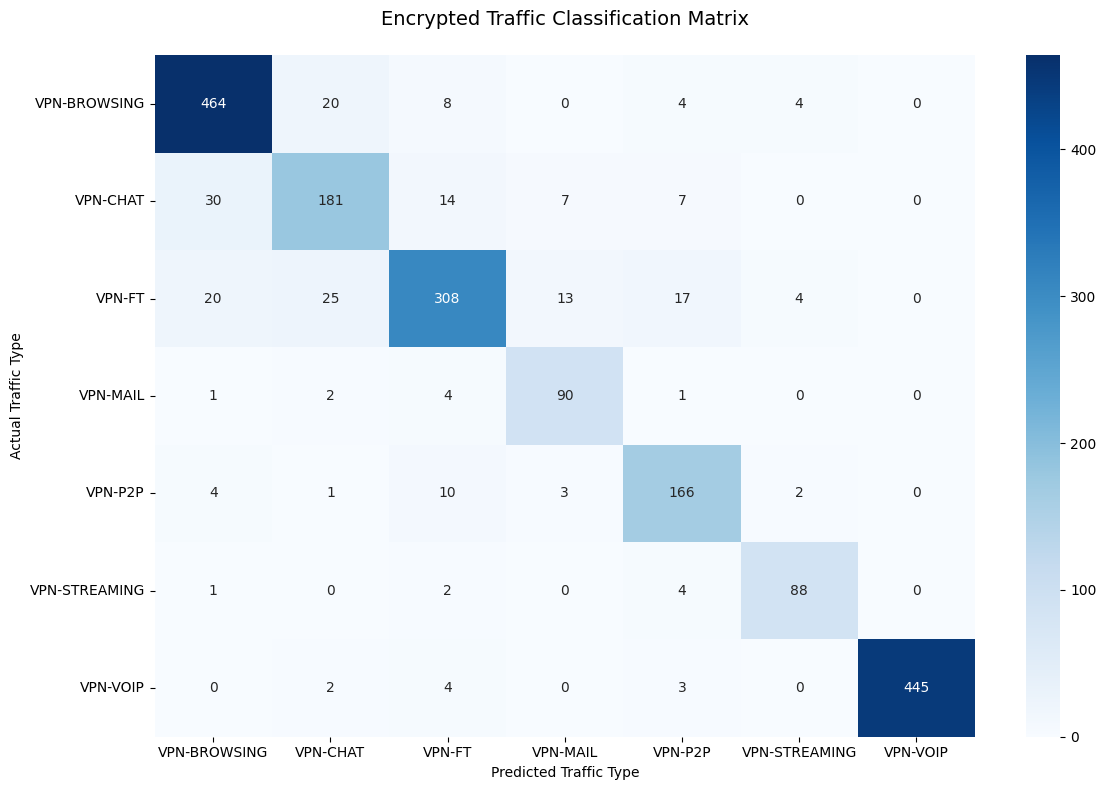

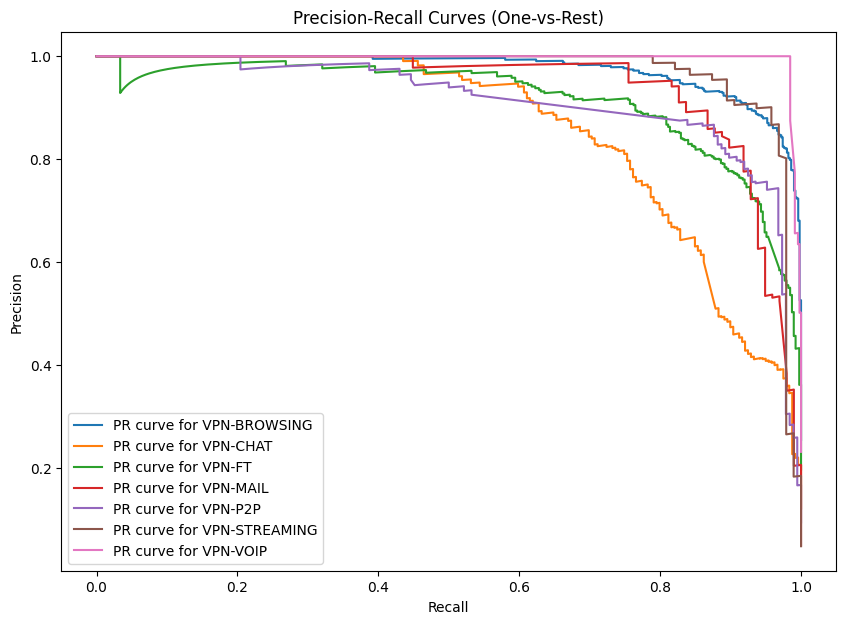


Top Features for Encrypted Traffic Classification:
               Feature  Importance
0          max_flowiat    0.970164
1   flowBytesPerSecond    0.944641
2    flowPktsPerSecond    0.934481
3         mean_flowiat    0.925720
4             max_fiat    0.916374
5            mean_fiat    0.889726
7           burstiness    0.878042
6            mean_biat    0.875493
8             duration    0.850495
10         std_flowiat    0.813609
9           total_fiat    0.810562
11            max_biat    0.797349
12         min_flowiat    0.781310
14            min_biat    0.709409
13          total_biat    0.697404


In [18]:

# ---------------------
# Main Execution
# ---------------------
if __name__ == "__main__":
    # Load and preprocess data
    df = load_and_preprocess("TimeBasedFeatures-Dataset-15s-VPN.arff")
    df = engineer_features(df)
    
    # Prepare data for training
    le = LabelEncoder()
    y = le.fit_transform(df['class1'])
    X = df[["max_flowiat", "flowBytesPerSecond", "flowPktsPerSecond",
    "mean_flowiat", "max_fiat", "mean_fiat", "mean_biat",
    "burstiness", "duration", "total_fiat", "std_flowiat",
    "max_biat", "min_flowiat", "total_biat", "min_biat"
]]
    
    # Split data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2, 
        stratify=y, 
        random_state=42
    )
    
    # # Create and train optimized pipeline
    # pipeline = create_ensemble_pipeline()
    # param_grid = get_parameter_grid()
    
    # grid_search = GridSearchCV(
    #     pipeline,
    #     param_grid,
    #     cv=5,
    #     scoring='f1_macro',
    #     n_jobs=-1,                                                #Commenting this part out after first training
    #     verbose=2
    # )
    
    # print("Starting model training...")
    # grid_search.fit(X_train, y_train)
    # print("\nTraining completed!")
    
    # # Save best model and parameters
    # best_model = grid_search.best_estimator_
    # joblib.dump(best_model, 'encrypted_traffic_classifier.pkl')
    # with open('best_params.json', 'w') as f:
    #     json.dump(grid_search.best_params_, f)

    # REUSING OLD PARAMS NOW
    # Load best parameters
    with open('best_params.json', 'r') as f:
        best_params = json.load(f)
    
    # Create pipeline and set optimal parameters
    pipeline = create_ensemble_pipeline()
    pipeline.set_params(**best_params)
    
    # Train with best parameters (no grid search)
    print("Training with optimized parameters...")
    pipeline.fit(X_train, y_train)
    print("Training completed!")
    
    # Save the retrained model if needed
    joblib.dump(pipeline, 'encrypted_traffic_classifier_reused.pkl')
    joblib.dump(le, "label_encoder.pkl")

    # ... [Keep evaluation/visualization code unchanged] ...
    best_model = pipeline  # Use the pipeline as the best model


    
    # Evaluate performance
    print("\nBest Parameters:", best_params)      #Or grid_search.best_params_ for when we are training the model for the first time 
    print("\nClassification Report:")
    y_pred = best_model.predict(X_test)  # Critical fix for NameError
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Generate visual insights
    visualize_results(best_model, X_test, y_test, le)
    
    # Feature importance analysis
    feature_scores = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.named_steps['feature_selector'].scores_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop Features for Encrypted Traffic Classification:")
    print(feature_scores.head(15))

